In [0]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
from sklearn import tree
from sklearn.model_selection import GridSearchCV
import graphviz
from google.colab import drive

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

mkdir: cannot create directory ‘drive’: File exists
Error: Mountpoint drive should be an existing directory.


In [0]:
path = '/content/drive/17.831/Final Project/'

party_control_org = pd.read_csv(path + "House, Senate, Executive Party control.csv",  encoding = "cp1252")

start = int(party_control_org["Year"][0][:4])
end = int(party_control_org["Year"][len(party_control_org["Year"])-1][:4])

In [0]:
party_control_list = []

for i in range(start,end):
    index = (i - start)//2
    pres = party_control_org["President"][index]
    senate = party_control_org["Senate"][index]
    house = party_control_org["House"][index]
    if pres == senate and pres == house:
        gov  = "Unified"
        gov_marker = 1
        if pres == "R":
            party_marker = 1
        else:
            party_marker = 0
    else:
        gov = "Divided"
        gov_marker = 0
        party_marker = None
    party_control_list.append([i,pres,senate, house, gov, gov_marker, party_marker])
    
party_control = pd.DataFrame(party_control_list,columns=["Year", "President", "Senate", 
                                                         "House", "Divided/Unified",
                                                         "Gov Marker", "Party Marker"])

In [0]:
sp_returns = pd.read_csv(path + "S&P 500 Yearly Returns.csv")
df_congress = pd.read_csv(path + "congressional_approval.csv")
df_congress_year = df_congress[['Year', 'True Approval']].groupby(['Year']).mean()
df_debt = pd.read_csv(path + "us_debt.csv", encoding = "cp1252")
df_military = pd.read_csv(path + "military_size.csv")
df_inflation = pd.read_csv(path + "cpi.csv", encoding = "cp1252")
df_gdp =  pd.read_csv(path + "gdp.csv")

df_inflation["Change in CPI Index Percent"] = df_inflation["Change in CPI Index Percent"].str.rstrip('%').astype('float')
df_inflation = df_inflation.dropna()
df_inflation['Year'] = df_inflation['Year'].astype(int)


    Year  GDP Growth  Real GDP
0   2018        2.52     18.78
1   2017        2.80     18.32
2   2016        2.03     17.82
3   2015        1.90     17.47
4   2014        2.88     17.14
..   ...         ...       ...
84  1934       10.80      0.91
85  1933       -1.23      0.82
86  1932      -12.89      0.83
87  1931       -6.41      0.95
88  1930       -8.50      1.02

[89 rows x 3 columns]


In [0]:
df_data = pd.merge(party_control,sp_returns, how= 'outer', on = "Year")
df_data = pd.merge(df_data, df_congress_year, how = 'outer', on = "Year")
df_data = pd.merge(df_data, df_debt, how = 'outer', on = 'Year')
df_data = pd.merge(df_data, df_military, how = 'outer', on = 'Year')
df_data = pd.merge(df_data, df_inflation, how = 'outer', on = 'Year')
df_data = pd.merge(df_data, df_gdp, how = 'outer', on = 'Year')
df_data["Change in True Approval"] = df_data["True Approval"].diff()
df_data['Debt/GDP Ratio'] = df_data['Debt/GDP Ratio'].str.rstrip('%').astype('float') / 100.0
df_data["Debt"] = df_data["Debt"].replace('[\$,]', '', regex=True).astype('float')
df_data["Military Total"] = df_data["Military Total"].str.replace(',','').astype('float')
df_data["Change in Debt"], df_data["Change in Debt/GDP Ratio"], \
df_data["Change in Debt Percent"], df_data["Change in S&P Returns"], df_data["Change in Military Total"]= \
    df_data["Debt"].diff(), df_data["Debt/GDP Ratio"].diff(), df_data["Debt"].pct_change(), \
    df_data["S&P Returns"].diff(), df_data["Military Total"].diff()
df_data['President'], df_data['House'], df_data['Senate'] = df_data['President']+'President', df_data['House']+'House'\
    , df_data['Senate']+'Senate'
df_data['Adjusted Debt'] = df_data['Annual Average CPI Index'][112]*df_data["Debt"]/df_data['Annual Average CPI Index'] #2012 dollars
df_data["Change in Adjusted Debt Percent"], df_data['Change in Adjusted Debt'] = \
    df_data["Adjusted Debt"].pct_change(), df_data['Adjusted Debt'].diff()
df_data["Change in Real GDP"] = df_data["Real GDP"].diff()

In [0]:
# from IPython.display import display
# pd.options.display.max_columns = None
# display(df_data)

df_data.to_csv(path + "all_data.csv")
df_data.columns

Index(['Year', 'President', 'Senate', 'House', 'Divided/Unified', 'Gov Marker',
       'Party Marker', 'S&P Returns', 'True Approval', 'Debt',
       'Debt/GDP Ratio', 'Major Events by Presidential Term', 'Army', 'Navy',
       'Marine', 'Airforce', 'Military Total', 'Annual Average CPI Index',
       'Change in CPI Index Percent', 'GDP Growth', 'Real GDP',
       'Change in True Approval', 'Change in Debt', 'Change in Debt/GDP Ratio',
       'Change in Debt Percent', 'Change in S&P Returns',
       'Change in Military Total', 'Adjusted Debt',
       'Change in Adjusted Debt Percent', 'Change in Adjusted Debt',
       'Change in Real GDP'],
      dtype='object')

In [0]:
t_all = []
p_all = []
s_all = []

for col in  list(df_data.columns)[7:11] + list(df_data.columns)[16:]:
  df_col = df_data[['Year', 'Divided/Unified', col]].dropna()
  s_all.append(df_col.shape[0])
  t, p = stats.ttest_ind(pd.to_numeric(df_col[df_col['Divided/Unified'] == 'Unified'][col]), pd.to_numeric(df_col[df_col['Divided/Unified'] == 'Divided'][col]))
  t_all.append(t)
  p_all.append(p)

t_all = pd.Series(t_all)
p_all = pd.Series(p_all, index =  list(df_data.columns)[7:11] + list(df_data.columns)[16:], name = 'p Values')
df_ttest = pd.DataFrame(p_all)
df_ttest['Sample Size'] = pd.Series(s_all, index =  list(df_data.columns)[7:11] + list(df_data.columns)[16:])
df_ttest

,p Values,Sample Size
S&P Returns,0.194301,93
True Approval,0.335151,42
Debt,0.134864,90
Debt/GDP Ratio,0.841075,90
Military Total,0.258897,64
Annual Average CPI Index,0.000321,105
Change in CPI Index Percent,0.225341,105
GDP Growth,0.017581,89
Real GDP,0.008124,89
Change in True Approval,0.582389,39


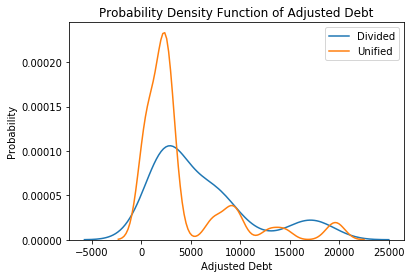

In [0]:
for col in df_ttest[df_ttest['p Values'] <= 0.06].index:
  plt.clf()
  sns.kdeplot(df_data[df_data['Divided/Unified'] == 'Divided'][col].dropna().rename("Divided"), )
  sns.kdeplot(df_data[df_data['Divided/Unified'] == 'Unified'][col].dropna().rename("Unified"))
  plt.title("Probability Density Function of " + col)
  plt.xlabel(col)
  plt.ylabel('Probability')
  plt.savefig(path + f"Figures/CDF-{col}.png")

In [0]:
def scatter(y, x, marker):
    fig, ax = plt.subplots()
    scatter = ax.scatter(x, y, c=marker, cmap="Spectral")
    plt.show()

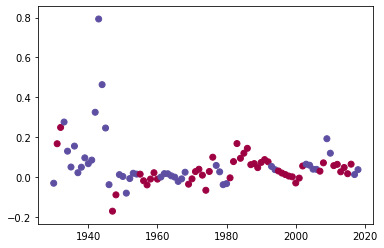

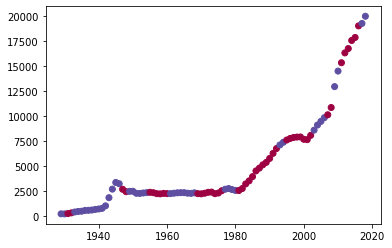

In [0]:
scatter(df_data["Change in Adjusted Debt Percent"], df_data["Year"], df_data["Gov Marker"])
scatter(df_data["Adjusted Debt"], df_data["Year"], df_data["Gov Marker"])

In [0]:
def lin_reg_categorical(model_name):
    fitted_model = model_name.fit()
    print(fitted_model.summary())

In [0]:
model_econ_parties = ols('Q("S&P Returns") ~ President+ Senate+ House', data = df_data, missing = 'drop')
model_delta_approval_parties = ols('Q("Change in True Approval") ~ C(President)+ C(Senate)+ C(House)', data = df_data, missing = 'drop')
model_approval_parties = ols('Q("True Approval") ~ C(President)+ C(Senate)+ C(House) + Year', data = df_data, missing = 'drop')
model_debt_parties = ols('Debt ~ C(President)+ C(Senate)+ C(House) +Year', data = df_data, missing = 'drop')
model_delta_debt_parties = ols('Q("Change in Debt") ~ C(President)+ C(Senate)+ C(House) +Year', data = df_data, missing = 'drop')
model_delta_percent_debt_parties = ols('Q("Change in Debt Percent") ~ C(President)+ C(Senate)+ C(House) +Year', data = df_data, missing = 'drop')
model_delta_debt_gdp_parties = ols('Q("Change in Debt/GDP Ratio") ~ President+ Senate+ House', data = df_data, missing = 'drop')

In [0]:
lin_reg_categorical(model_delta_debt_parties) #decent
lin_reg_categorical(model_debt_parties) #really good
lin_reg_categorical(model_delta_percent_debt_parties)

                             OLS Regression Results                            
Dep. Variable:     Q("Change in Debt")   R-squared:                       0.534
Model:                             OLS   Adj. R-squared:                  0.511
Method:                  Least Squares   F-statistic:                     24.03
Date:                 Mon, 09 Dec 2019   Prob (F-statistic):           2.86e-13
Time:                         10:12:09   Log-Likelihood:                -625.56
No. Observations:                   89   AIC:                             1261.
Df Residuals:                       84   BIC:                             1274.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept 

In [0]:
def lin_reg_categorical_input(y, x_inputs):
    ols_string = f'Q("{y}") ~ '
    for x in x_inputs:
        ols_string += f'Q("{x}") +'
    ols_string = ols_string[:-1]
    model = ols(ols_string, data = df_data, missing = 'drop')
    fitted_model = model.fit()
    print(fitted_model.summary())

In [0]:
lin_reg_categorical_input("True Approval", ['President', 'House','Senate', 'Year'])
lin_reg_categorical_input("Military Total", ['President', 'House','Senate']) #ok
lin_reg_categorical_input("Change in Military Total", ['President', 'House','Senate'])
lin_reg_categorical_input("Change in Adjusted Debt", ['President', 'House','Senate'])
lin_reg_categorical_input("Change in Adjusted Debt Percent", ['President', 'House','Senate'])

                            OLS Regression Results                            
Dep. Variable:     Q("True Approval")   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     7.113
Date:                Mon, 09 Dec 2019   Prob (F-statistic):           0.000236
Time:                        10:12:15   Log-Likelihood:                -156.66
No. Observations:                  42   AIC:                             323.3
Df Residuals:                      37   BIC:                             332.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [0]:
df_data.columns

Index(['Year', 'President', 'Senate', 'House', 'Divided/Unified', 'Gov Marker',
       'Party Marker', 'S&P Returns', 'True Approval', 'Debt',
       'Debt/GDP Ratio', 'Major Events by Presidential Term', 'Army', 'Navy',
       'Marine', 'Airforce', 'Military Total', 'Annual Average CPI Index',
       'Change in CPI Index Percent', 'GDP Growth', 'Real GDP',
       'Change in True Approval', 'Change in Debt', 'Change in Debt/GDP Ratio',
       'Change in Debt Percent', 'Change in S&P Returns',
       'Change in Military Total', 'Adjusted Debt',
       'Change in Adjusted Debt Percent', 'Change in Adjusted Debt',
       'Change in Real GDP'],
      dtype='object')

In [0]:
def lin_reg(y, x_factors):
    X = df_data[x_factors]
    Y = df_data[y]
    results = sm.OLS(Y,sm.add_constant(X), missing = 'drop').fit()
    print(results.summary())

def lin_reg_plot(y, x_factor):
    %matplotlib inline
    X = df_data[x_factor]
    Y = df_data[y]
    results = sm.OLS(Y,sm.add_constant(X), missing = 'drop').fit()
    slope = results.params[0]
    intercept = results.params[1]
    plt.scatter(X, Y, c = 'g')
    plt.xlabel("Government Marker (Divided = 0, Unified = 1)")
    plt.ylabel(y[0])
    plt.plot(X, intercept+slope*X, label = f'y = {round(slope, 3)}*x + {round(intercept,3)} \n R^2 = {round(results.rsquared,3)}')
    plt.legend(loc='lower right')
    plt.title(f"{y[0]} versus {' '.join(x_factor)}")
    plt.savefig(path + f"Figures/LinReg-{y[0]}_vs_{' '.join(x_factor)}.png")
    return(round(slope, 3), round(intercept, 3), round(results.rsquared,3))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


(107.667, -52.835, 0.119)

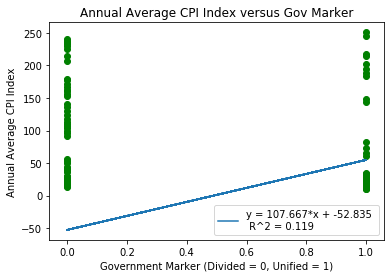

In [0]:
lin_reg_plot(["Annual Average CPI Index"],["Gov Marker"])

In [0]:
df_data[df_data["Annual Average CPI Index"] < 0].shape

(0, 31)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,Intercept,Slope,R^2
S&P Returns,5.338,9.182,0.018
True Approval,-4.338,36.300,0.023
Debt,-1729.461,4354.848,0.025
Debt/GDP Ratio,0.010,0.569,0.000
Military Total,188175.310,1994950.690,0.021
Annual Average CPI Index,-52.835,107.667,0.119
Change in CPI Index Percent,-1.142,3.856,0.014
GDP Growth,2.480,2.150,0.063
Real GDP,-3.001,8.696,0.078
Change in True Approval,-1.713,0.213,0.008


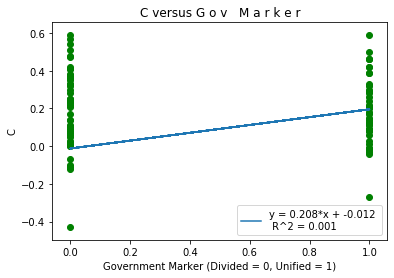

In [0]:
r_squared = []
slope = []
intercept = []

for col in  list(df_data.columns)[7:11] + list(df_data.columns)[16:]:
    df_col = df_data[['Year', 'Gov Marker', col]].dropna()
    lin_reg_plot(col,'Gov Marker')
    results = lin_reg_plot(col,'Gov Marker')
    slope.append(results[0])
    intercept.append(results[1])
    r_squared.append(results[2])
    

intercept = pd.Series(intercept, index =  list(df_data.columns)[7:11] + list(df_data.columns)[16:], name = 'Intercept')
df_linreg = pd.DataFrame(intercept)
df_linreg['Slope'] = pd.Series(slope, index =  list(df_data.columns)[7:11] + list(df_data.columns)[16:])
df_linreg["R^2"] = pd.Series(r_squared, index =  list(df_data.columns)[7:11] + list(df_data.columns)[16:])
df_linreg

In [0]:
lin_reg(["Change in Debt/GDP Ratio"],["Gov Marker"])
lin_reg(["True Approval"], ["Gov Marker", "Year"]) #indicative
lin_reg(["Military Total"],["Gov Marker"])

                               OLS Regression Results                               
Dep. Variable:     Change in Debt/GDP Ratio   R-squared:                       0.019
Model:                                  OLS   Adj. R-squared:                  0.007
Method:                       Least Squares   F-statistic:                     1.645
Date:                      Sat, 16 Nov 2019   Prob (F-statistic):              0.203
Time:                              02:25:01   Log-Likelihood:                 128.32
No. Observations:                        89   AIC:                            -252.6
Df Residuals:                            87   BIC:                            -247.7
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [0]:
def cart_one_hot(y, x_input,depth = None):
    a = df_data[x_input+[y]].dropna()
    one_hot_data = pd.get_dummies(a[x_input], dummy_na=True)
    clf = tree.DecisionTreeClassifier(max_depth = depth)
    clf = clf.fit(one_hot_data, a[y])
    dot_data = tree.export_graphviz(clf, out_file=None)
    graph = graphviz.Source(dot_data)
    return(graph)
    # graph.render("iris")
#     tree.plot_tree(clf.fit(one_hot_data, a[y]))
#     plt.show()

In [0]:
df_data.columns

Index(['Year', 'President', 'Senate', 'House', 'Divided/Unified', 'Gov Marker',
       'Party Marker', 'S&P Returns', 'True Approval', 'Debt',
       'Debt/GDP Ratio', 'Major Events by Presidential Term', 'Army', 'Navy',
       'Marine', 'Airforce', 'Military Total', 'Annual Average CPI Index',
       'Change in CPI Index Percent', 'Change in True Approval',
       'Change in Debt', 'Change in Debt/GDP Ratio', 'Change in Debt Percent',
       'Change in S&P Returns', 'Change in Military Total', 'Adjusted Debt',
       'Change in Adjusted Debt Percent', 'Change in Adjusted Debt'],
      dtype='object')

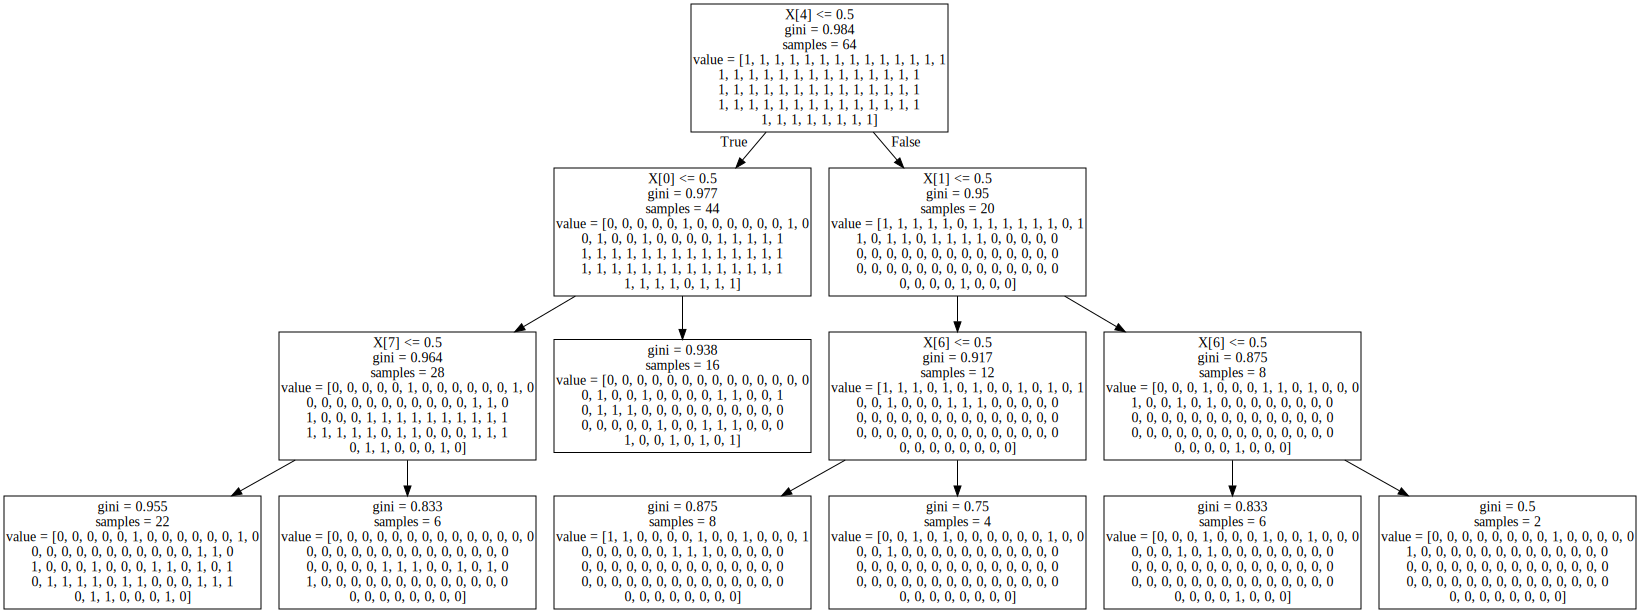

In [0]:
cart_one_hot("Military Total", ['President', 'House', 'Senate'])

In [0]:
def cart(y, x_input, depth = None):
    a = df_data[x_input+[y]].dropna()
#     one_hot_data = pd.get_dummies(a[x_input], dummy_na=True)
    clf = tree.DecisionTreeClassifier(max_depth=depth)
    clf = clf.fit(a[x_input], a[y])
    dot_data = tree.export_graphviz(clf, out_file=None)
    graph = graphviz.Source(dot_data)
    return(graph)

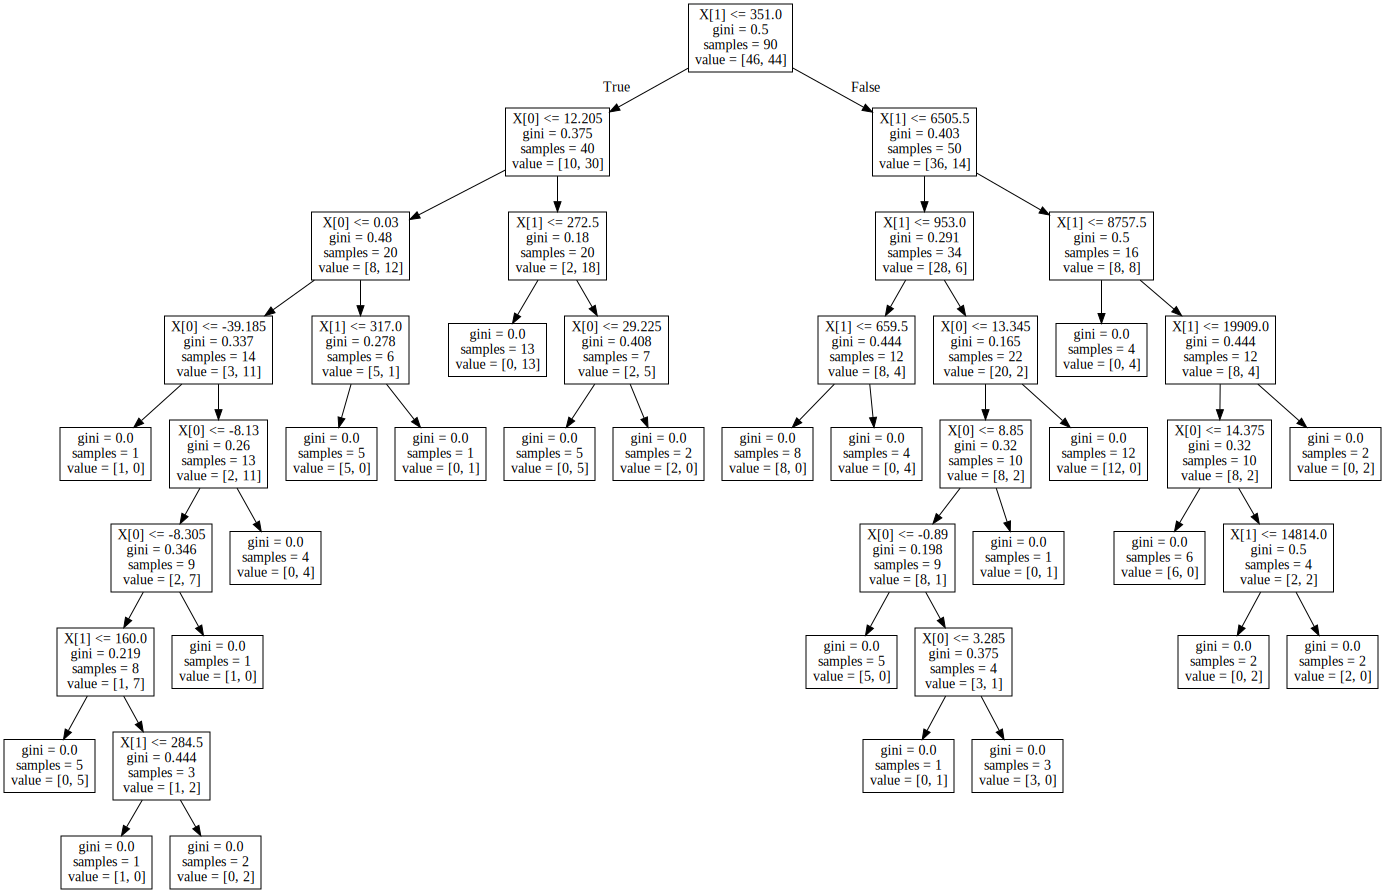

In [0]:
cart("Divided/Unified", ['S&P Returns', 'Debt'])

In [0]:
y = "Divided/Unified"
# x_input = ['Change in Military Total', 'Debt', 'True Approval'] #its ok
# x_input = ['Military Total', 'Change in Debt/GDP Ratio', 'True Approval'] #best so far 6 and 8 depth
x_input = ['Military Total', 'Debt/GDP Ratio', 'True Approval']
df_data.columns

Index(['Year', 'President', 'Senate', 'House', 'Divided/Unified', 'Gov Marker',
       'Party Marker', 'S&P Returns', 'True Approval', 'Debt',
       'Debt/GDP Ratio', 'Major Events by Presidential Term', 'Army', 'Navy',
       'Marine', 'Airforce', 'Military Total', 'Change in True Approval',
       'Change in Debt', 'Change in Debt/GDP Ratio', 'Change in Debt Percent',
       'Change in S&P Returns', 'Change in Military Total'],
      dtype='object')

In [0]:
def cart_validation_graph(y, x_input, depth = 10):
    parameters = {'max_depth':range(1,depth)}
    a = df_data[x_input+[y]].dropna()
    clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
    clf = clf.fit(a[x_input], a[y])
    tree_model = clf.best_estimator_
    print (clf.best_score_, clf.best_params_) 
    dot_data = tree.export_graphviz(tree_model, out_file=None, feature_names = x_input, class_names = df_data[y].unique(), 
                                    filled=True, rounded=True) 
    graph = graphviz.Source(dot_data)
    return(graph)

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.6341463414634146 {'max_depth': 3}


C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


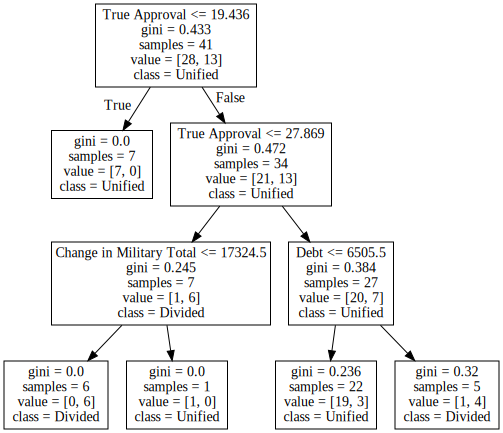

In [0]:
cart_validation_graph("Divided/Unified", ['Change in Military Total', 'Debt', 'True Approval'])

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.7560975609756098 {'max_depth': 5}


C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


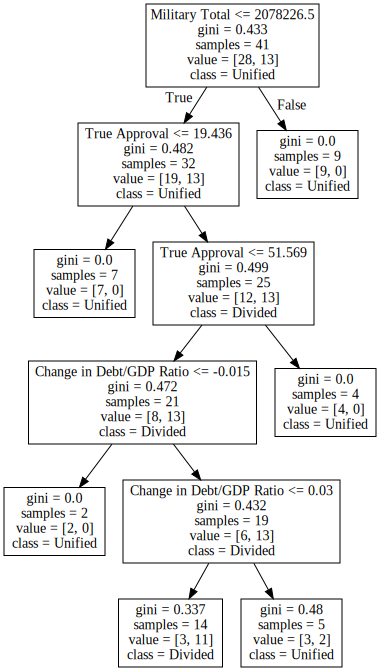

In [0]:
cart_validation_graph("Divided/Unified", ['Military Total', 'Change in Debt/GDP Ratio', 'True Approval'], depth =6)

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.7073170731707317 {'max_depth': 5}


C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


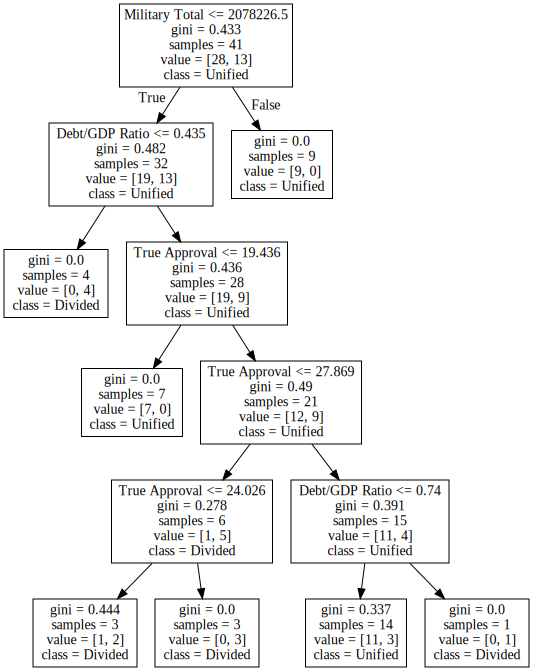

In [0]:
cart_validation_graph("Divided/Unified", ['Military Total', 'Debt/GDP Ratio', 'True Approval'])

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.7073170731707317 {'max_depth': 6}


C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


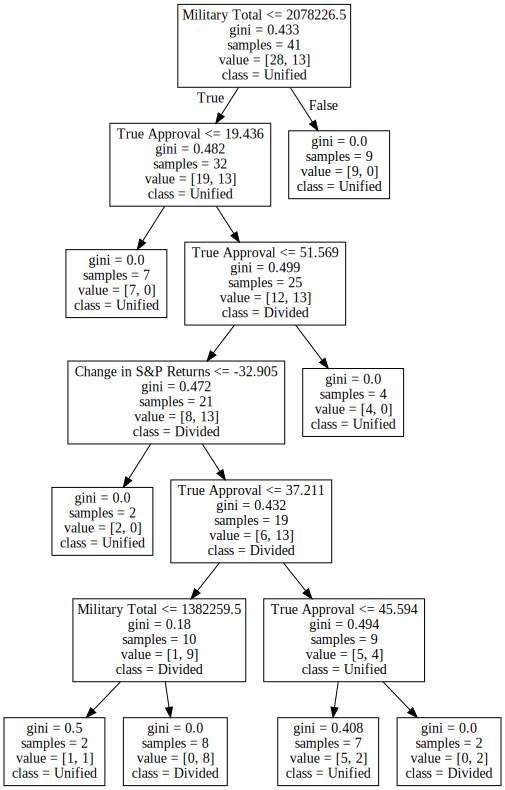

In [0]:
cart_validation_graph("Divided/Unified", ['Military Total',  'Change in S&P Returns', 'True Approval'])

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.6052631578947368 {'max_depth': 1}


C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


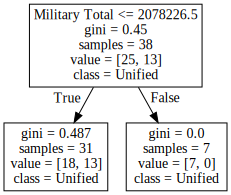

In [0]:
cart_validation_graph("Divided/Unified", ['Military Total',  'Change in S&P Returns', 'Change in True Approval'])

In [0]:
list(df_data.columns)

['Year',
 'President',
 'Senate',
 'House',
 'Divided/Unified',
 'Gov Marker',
 'Party Marker',
 'S&P Returns',
 'True Approval',
 'Debt',
 'Debt/GDP Ratio',
 'Major Events by\xa0Presidential Term',
 'Army',
 'Navy',
 'Marine',
 'Airforce',
 'Military Total',
 'Annual Average CPI Index',
 'Change in CPI Index Percent',
 'GDP Growth',
 'Real GDP',
 'Change in True Approval',
 'Change in Debt',
 'Change in Debt/GDP Ratio',
 'Change in Debt Percent',
 'Change in S&P Returns',
 'Change in Military Total',
 'Adjusted Debt',
 'Change in Adjusted Debt Percent',
 'Change in Adjusted Debt',
 'Change in Real GDP']

In [0]:
import itertools
relevant_data = list(df_data.columns)[16:] + list(df_data.columns)[7:][:4]
# print(list(df_data.columns)[16:])
# print(list(df_data.columns)[7:][:4])

def valid_combos(relevant_data, size):
    subsets_tuples = list(itertools.combinations(relevant_data, size))
    subsets_tuples_copy = subsets_tuples.copy()
    for subset in subsets_tuples_copy:
        for element in subset:
            subset_copy_remove = list(subset).copy()
            subset_copy_remove.remove(element)
#             print(element, subset)
#             print(list(subset).remove(element))
            if any(element in s for s in subset_copy_remove): #dont put delta and normal in the same list
                subsets_tuples.remove(subset)
                break
    return subsets_tuples

valid_x_inputs = valid_combos(relevant_data, 3)            

In [0]:
def cart_validation(y, x_input, depth = 7):
    parameters = {'max_depth':range(1,depth)}
    a = df_data[x_input+[y]].dropna()
    clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
    clf = clf.fit(a[x_input], a[y])
    tree_model = clf.best_estimator_
    return((clf.best_score_, clf.best_params_['max_depth'])) 

In [0]:
from tqdm import tqdm_notebook as tqdm

cart_results_dict = {}
for inputs in tqdm(valid_x_inputs, total = len(valid_x_inputs)):
    results = cart_validation("Divided/Unified", list(inputs))
    if results[0] > 0.5:
        cart_results_dict[inputs] = results
    

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and wil

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and wil

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and wil

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and wil

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and wil

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and wil

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and wil

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and wil

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and wil

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and wil

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and wil

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and wil

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to sile

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and wil

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and wil

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric re

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and wil

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and wil

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and wil

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and wil

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and wil

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and wil

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, Fut

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and wil

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric re

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to

C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [0]:
sorted_results_dict = sorted(cart_results_dict.items(), key=lambda x: x[1], reverse=True)
# print(sorted_results_dict[:30])

In [0]:
def cart_validation_graph_export(y, x_input, i, depth = 10):
    parameters = {'max_depth':range(1,depth)}
    a = df_data[x_input+[y]].dropna()
    clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
    clf = clf.fit(a[x_input], a[y])
    tree_model = clf.best_estimator_
    print (clf.best_score_, clf.best_params_) 
    dot_data = tree.export_graphviz(tree_model, out_file=None, feature_names = x_input, class_names = df_data[y].unique(), 
                                    filled=True, rounded=True) 
    graph = graphviz.Source(dot_data) 
    graph.render(f'{", ".join(x_input).replace("/","-")}') 

In [0]:
for i in range(10):
    x_input = list(sorted_results_dict[i][0])
    print(x_input)
    y = "Divided/Unified"
    cart_validation_graph_export(y, x_input,i, depth = 6)

['Change in Debt/GDP Ratio', 'Change in Military Total', 'True Approval']


C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.6585365853658537 {'max_depth': 2}
['Military Total', 'Change in Debt/GDP Ratio', 'True Approval']


C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7073170731707317 {'max_depth': 5}
['Change in Military Total', 'True Approval', 'Debt/GDP Ratio']


C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7560975609756098 {'max_depth': 4}
['Change in Debt/GDP Ratio', 'Change in S&P Returns', 'True Approval']


C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7142857142857143 {'max_depth': 5}
['Military Total', 'Change in S&P Returns', 'True Approval']


C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7073170731707317 {'max_depth': 5}
['Change in Military Total', 'S&P Returns', 'True Approval']


C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7317073170731707 {'max_depth': 5}
['Change in Debt/GDP Ratio', 'Change in Debt Percent', 'Change in Military Total']


C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.6984126984126984 {'max_depth': 4}
['Change in CPI Index Percent', 'True Approval', 'Debt/GDP Ratio']


C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.6666666666666666 {'max_depth': 2}
['Change in S&P Returns', 'True Approval', 'Debt']


C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.6904761904761905 {'max_depth': 5}
['Change in CPI Index Percent', 'Change in Debt/GDP Ratio', 'True Approval']


C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.6904761904761905 {'max_depth': 2}


C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\shawn\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.7142857142857143 {'max_depth': 6}


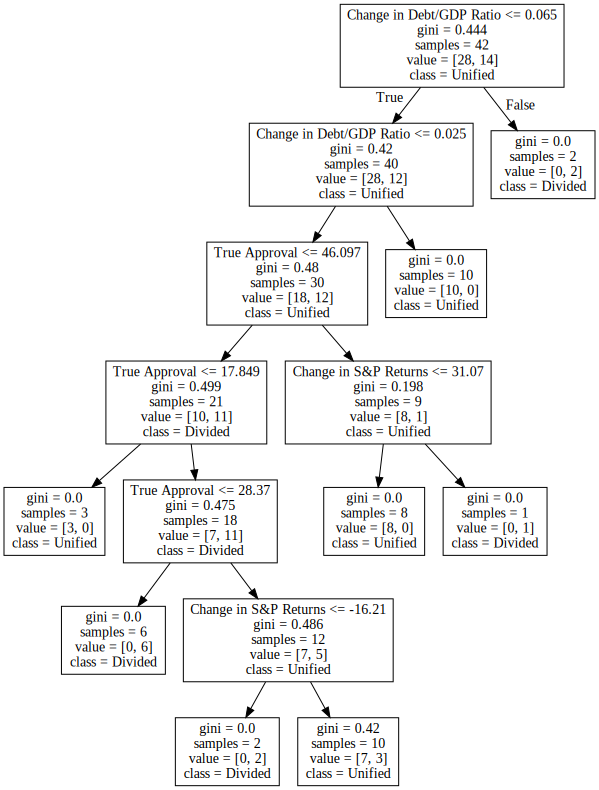

In [0]:
cart_validation_graph("Divided/Unified", ['Change in Debt/GDP Ratio', 'Change in S&P Returns', 'True Approval'])

In [0]:
>>> from sklearn.datasets import load_iris
>>> from sklearn import tree
>>> iris = load_iris()
>>> clf = tree.DecisionTreeClassifier()
>>> clf = clf.fit(iris.data, iris.target)
>>> dot_data = tree.export_graphviz(clf, out_file=None) 
>>> graph = graphviz.Source(dot_data) 
>>> graph.render("iris") 

'iris.pdf'

In [0]:
from sklearn.datasets import load_iris
>>> from sklearn.tree import DecisionTreeClassifier
>>> from sklearn.tree.export import export_text
>>> iris = load_iris()
>>> X = iris['data']
>>> y = iris['target']
>>> decision_tree = DecisionTreeClassifier(random_state=0, max_depth=2)
>>> decision_tree = decision_tree.fit(X, y)
>>> r = export_text(decision_tree, feature_names=iris['feature_names'])
>>> print(r)

|--- petal width (cm) <= 0.80
|   |--- class: 0
|--- petal width (cm) >  0.80
|   |--- petal width (cm) <= 1.75
|   |   |--- class: 1
|   |--- petal width (cm) >  1.75
|   |   |--- class: 2



In [0]:
print(iris['feature_names'])
iris.target_names

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [0]:
>>> from sklearn.datasets import load_iris
>>> from sklearn import tree
>>> iris = load_iris()
>>> clf = tree.DecisionTreeClassifier()
>>> clf = clf.fit(iris.data, iris.target)
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

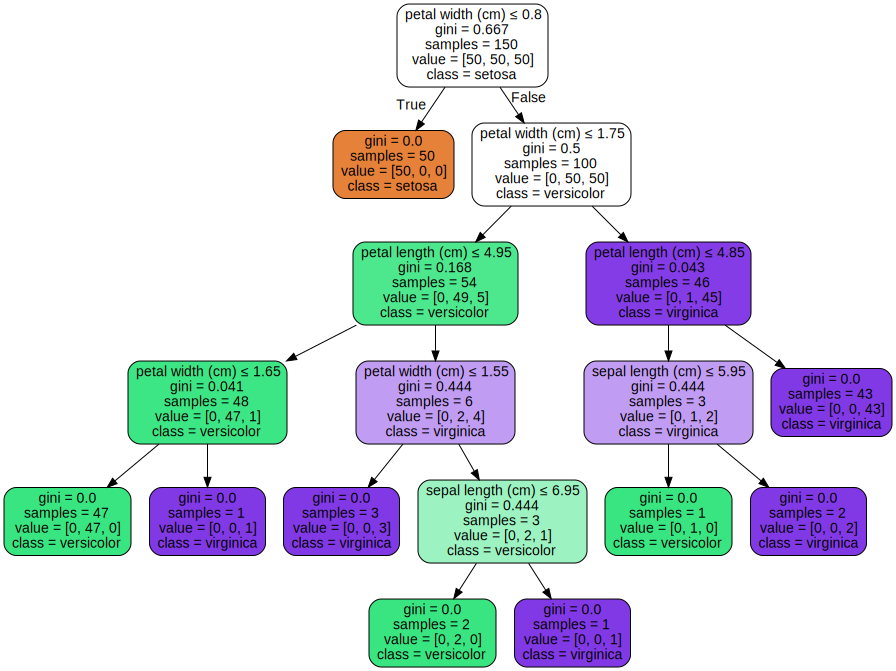

In [0]:
>>> dot_data = tree.export_graphviz(clf, out_file=None, 
...                      feature_names=iris.feature_names,  
...                      class_names=iris.target_names,  
...                      filled=True, rounded=True,  
...                      special_characters=True)  
>>> graph = graphviz.Source(dot_data)  
>>> graph 